In [91]:
%matplotlib inline
import urllib2
import re
import sys
from astropy.io import fits
import numpy as np
import datetime
import time
import thread
from astropy.coordinates import SkyCoord
import astropy.units as u
from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.pyplot import subplots, show, pause, get_fignums, figure, subplot, cm
from matplotlib import gridspec
from copy import copy
import richardsplot as rplot
import gc
import palettable
from JacksTools import jio


# Everything down to cell 7 is imports and definitions, watch for errors!

In [103]:
def searchProposal(Proposal, campaign = 8): #Seach a proposal number for EPIC IDs, returns a dict with EPIC IDs as keys to RA and DEC coords

    socket = urllib2.urlopen('https://www.cfa.harvard.edu/~avanderb/allk2c%iobs.html' % campaign)
    body = socket.read()

    pattern = "EPIC (\d{9})</a>, Kp = (\d+\.\d+), RA = (\d+\.\d+), Dec = (-?\d+\.\d+).+%s" % Proposal
    matches = re.findall(pattern, body)
    socket.close()
    EPIC = [int(i[0]) for i in matches]
    coords = [(float(i[1]), float(i[2]), float(i[3])) for i in matches]
    Result = dict(zip(EPIC, coords))
    
    return Result

def search(target_file):
    data = jio.load(target_file, delimiter=', ', headed=True)
    EPIC = data['EPIC ID']
    RA = map(float, filter(None,data['RA (J2000) [deg]']))
    DEC = map(float, filter(None,data['Dec (J2000) [deg]']))
    MAG = map(float, filter(None,data['magnitude']))
    return {epic: (mag, ra, dec) for epic, mag, ra, dec in zip(EPIC, MAG, RA, DEC)}

def downloadVJ(EPIC, campaign):
    EPIC = str(EPIC)
    base_url = "http://archive.stsci.edu/missions/hlsp/k2sff"
    path = "c%02i/%s00000/%s" % (campaign, EPIC[:4], EPIC[4:])
    base_name = "hlsp_k2sff_k2_lightcurve_%s-c%02i_kepler_v1_llc.fits" % (EPIC, campaign)
    filename = '/'.join((base_url, path, base_name))
    for i in xrange(5): #Timeouts are common, just need to retry
        try:
            #Set memmap and cache to False if you get an error about too many open files
            hdulist = fits.open(filename, memmap = True, cache = True)
            return hdulist
        except urllib2.URLError:
            print "Timeout Error, Retrying: Attempt %i/5" % (i+1)
            if not (i+1) % 5:
                print "LC Download Failed, Will Continue Without %s" % str(EPIC)
    return None

def download_target_pixels(EPIC, campaign):

    base_url = 'https://archive.stsci.edu/missions/k2/target_pixel_files/'
    path = 'c%i/%i00000/%02i000/' % (campaign, EPIC / 100000, (EPIC % 100000)/1000)
    filename = 'ktwo%i-c%02i_lpd-targ.fits.gz' % (EPIC, campaign)
    url = base_url + path + filename
    #print url # print if verbose
    hdu = fits.open(url, memmap=False, cache=True)
    return hdu

In [104]:
'''
K2FOV.py - Tools for working with k2 fields

Author: Jack O'Brien
Date: 10/19/2017

Execution: python 2.7
Requires: numpy, matplotlib, JacksTools

Usage:
    Can plot a field from a campaign
    Can determine if an object lies within a field
    Tools for placing objects within a k2 campaign field
'''
import os
#BASE_DIR = os.path.dirname(os.path.abspath(__file__))
BASE_DIR = "/home/rodot/Documents/Research/Git-CARMA/"

try:

    from JacksTools import jio
except ImportError as e:
    print("Please install JacksTools")
    print("$ pip install JacksTools")
    raise ImportError
import numpy as np
from matplotlib.pyplot import subplots, show

FOOTPRINT_FILE=os.path.join(BASE_DIR,"data/k2-footprint.csv")

class Field:
    ''' A single K2 campaign feild
        Relevant methods for end user:
            plot_field
            test_point
    This thing sort of works as a state machine underneath
    '''
    data = jio.load(FOOTPRINT_FILE, headed=True, delimiter=',')
    # This array of tuples iterates over adjacent edges of a square
    grouping = zip(np.arange(4), (np.arange(4)+1)%4)

    def __init__(self, campaign, cache_data=True):

        self.campaign = campaign
        self.cache = cache_data
        self.footprint = self._get_campaign(campaign)
        self.length = len(self.footprint)
        self.ra = np.array([self.footprint['ra'+i] for i in '0123'])
        self.dec = np.array([self.footprint['dec'+i] for i in '0123'])
        self.bounding_box = self.__get_bounding_box()
        self.bbox_set = tuple(map(self.__get_bounding_box, xrange(len(self))))
        mask = self.footprint['module'] == 13 # Module 13 is the center module
        self.center = {'ra':np.mean(self.ra[:,mask]), 'dec':np.mean(self.dec[:,mask])}

    def plot_field(self, ax, label=False): # TODO: update this to use self.ra and self.dec
        ''' plot the footprint on an axis '''
        fp = self.footprint # For shorter typing 
        sqr = np.arange(5)%4 # indeces of box corners
        for idx, ccd in enumerate(self): # Iterate over the CCDs
            # Grab the box corners, complete the shape by repeating first term
            ax.plot(self.ra[sqr, idx], self.dec[sqr, idx], color='k', lw=1)
        if label: # You can set the label to True or a string
            if type(label) is bool:
                label="Campaign %i" % self.campaign
            ax.text(self.center['ra'], self.center['dec'], str(self.campaign), fontsize = 25)

    def test_point(self, ra, dec):
        ''' test if a point is inside a field, return the channel number '''

        top, right, bottom, left = self.bounding_box
        if not (left < ra < right) or not (bottom < dec < top): #Check Full Field bbox
            return 0,0
        for idx, ccd in enumerate(self): # Iterate over the channels
            top, right, bottom, left = self.bbox_set[idx]
            if left < ra < right and bottom < dec < top: #Check channel bbox
                test = self.__test_channel(idx, ra, dec)
                t0 = test.next() # Get the first truth value
                for t in test:
                    if t is not t0: # All we care about is all elements are uniform
                        break
                else:
                    return ccd['module'], ccd['channel'] #NOTE: THIS WAS CHANNEL BEFORE
        return 0,0

    @classmethod
    def _get_campaign(self, campaign):
        ''' get the footprint of a campaign '''
        fp = self.data[self.data['campaign'] == campaign]
        # Place RA on scale from -180 to 180 in degrees
        if any(ra > 180 for i in '0123' for ra in fp['ra'+i]):
            for i in '0123': fp['ra'+i][::] -= 360
        return fp

    def __test_channel(self, idx, ra, dec):
        ''' Test if a point at ra and dec are within the bbox of a channel 
            This works by taking vectors describing the channel edges and
            taking the cross product with a vector defined by the point relative
            to the first point in the edge vector.  If the cross product of these
            vectors is the same sign for all edges, then the point must be contained
            within the box.  This method is a generator which yeilds a boolean
            describing the sign of the cross product (True for positive, 
            False for negative)
        '''
        ccd_ra, ccd_dec = self.ra[:,idx], self.dec[:,idx]
        for i,j in self.grouping:
            # Compute the edge vector
            dra, ddec = ccd_ra[j] - ccd_ra[i], ccd_dec[j] - ccd_dec[i]
            # Compute the point to vertex vector
            dpra, dpdec = ra - ccd_ra[i], dec - ccd_dec[i]
            # Compute the cross product
            pos = dra*dpdec - ddec*dpra
            yield pos > 0

    def __get_bounding_box(self, idx=None):
        ''' get a box that bounds the edge of the field (t,r,b,l)'''
        if idx is None:
            ra, dec = self.ra, self.dec
        else:
            ra, dec = self.ra[:,idx], self.dec[:,idx]
        top = dec.max()
        right = ra.max()
        bottom = dec.min()
        left = ra.min()
        return top, right, bottom, left

    def __len__(self):
        ''' just get the number of elements in the footprint '''
        return self.length

    def __iter__(self):
        ''' iterate over elements of the footprint list '''
        for ccd in self.footprint:
            yield ccd


In [105]:

class DummyModule(object):
    def __init__(self, params):
        self.__dict__.update(params)
        
K2FOV = DummyModule({'Field':Field})
downloader = DummyModule({'downloadVJ':downloadVJ,
                          'download_target_pixels':download_target_pixels})
class LoadingBar:

    def __init__(self):

        self.is_running = True
        #self.mapping = '_.-^-.'
        self.mapping = '-/|\\'
        self.N = len(self.mapping)
        self.n = self.N*2
        self.n = 1
        self.blank = (' '*(self.n+2)).join('\r\r')
        self.done = False
        
    def print_loading_bar(self):

        N = self.N
        n = self.n
        while self.is_running:
            for j in xrange(N):
                sys.stdout.write(self.blank)
                for i in xrange(j,j+n):
                    sys.stdout.write('('+self.mapping[i%N]+')')
                sys.stdout.flush()
                if not self.is_running:
                    self.done = True
                    break
                time.sleep(0.1)
        self.done=True
        
    def print_bar(self):
        
        self.blank = (" "*(self.N+4)).join("\r\r")
        self.N = 60
        while self.is_running:
            
            for j in xrange(len(self.mapping)):
                sys.stdout.write(self.blank)
                string = "[" + "#"*self.n +self.mapping[j] + '-'*(self.N-1-self.n) + "]"
                sys.stdout.write(string)
                sys.stdout.flush()
                if not self.is_running:
                    self.done = True
                    break
                time.sleep(0.1)
        self.done = True
        
        
    def set_as_bar(self):
        
        self.print_loading_bar = self.print_bar
        
    
    def update_bar(self, percentage):
        self.n = int(percentage * self.N)

    def __enter__(self):

        self.done=False
        self.is_running=True
        thread.start_new_thread(self.print_loading_bar, ())

    def __exit__(self, *args):

        N = self.N
        n = self.n
        self.is_running = False
        while not self.done:
            time.sleep(0.001)
        sys.stdout.write(self.blank)
        sys.stdout.flush()


In [106]:
# Now we'll look at functions for extracting target pixels based on the module

def moduleFilter(module, channel, campaign):
    K2FOV = Field(campaign)

    def _filter(item):
        ra, dec = item[1][1:]
        mod, chan = K2FOV.test_point(ra,dec)
        return (module == mod) and (chan == channel)
    return _filter


def getObjects(module, channel, campaign):
    
    objs = searchProposal("GO", campaign)
    #objs = search("/home/rodot/Documents/Research/Git-CARMA/data/K2Campaign8targets.csv")
    objs = filter(moduleFilter(module, channel, campaign), objs.iteritems())
    objs = dict(objs)

    return objs

#Grab the target pixels (or at least see if the computer can handle them)
#Note: check for pixel overlap when creating full map
# Don't do all the downloading at once

def getPixels(epics, campaign):
    for epic in epics:
        yield download_target_pixels(epic, campaign)


In [107]:
# Select here for flux or raw counts in the pixels
#DATA="FLUX"
DATA="RAW_CNTS"
class BasicFitsContainer:
    
    def __init__(self, hdu):
        self.pixels = np.array(copy(hdu[1].data[DATA]))
        self.m, self.n = self.pixels[0].shape #WARNING! I swapped n and m, make sure that is right
        self.col = hdu[1].header['1CRV9P']
        self.row = hdu[1].header['2CRV9P']
        #print self.row, self.row+self.m, self.col, self.col+self.n, np.sum(self.pixels[0])
        del hdu
        
class PixelMapContainer:
    
    def __init__(self, objs, campaign, bar = None):
        self.objs = objs
        self.containers = []
        self.campaign = campaign
        self.load(bar)
        self.stats = None
        
    def load(self, bar=None):
        
        for i, hdu in enumerate(getPixels(self.objs.iterkeys(), self.campaign)):
            if bar is not None:
                bar.update_bar(1.0*i/len(self.objs.keys()))
            self.containers.append(BasicFitsContainer(hdu))
            hdu.close()
            del hdu
            gc.collect()

    def __getitem__(self, i):
        return self.containers[i]

    def __iter__(self):
        return self.containers
        
class PixMapGenerator:
        
    def __init__(self, PixContainer):
        self.buff = np.zeros((1150,1150), dtype=np.float64)
        self.containers = PixContainer.containers
        self.stats = None
            
    def __iter__(self):
        for i in xrange(N):
            self.buff[::] = 0
            for c in self.containers:
                self.buff[c.row:c.row+c.m,c.col:c.col+c.n] = c.pixels[i]
            yield self.buff
            
    def build_stats_cache(self):
        self.stats = {'std':[],'med':[],'mean':[]}
        for c in self.containers:
            data = copy(c.pixels*1.0)
            if DATA == 'RAW_CNTS':
                data[data <= 0.5] = np.nan
            data = np.log10(data)
            self.stats["std"].append(np.nanstd(data, axis=0))
            #print "D0, std, std",data[0], self.stats['std'][-1], np.nanstd(data, axis=0)
            self.stats["med"].append(np.nanmedian(data, axis=0))
            self.stats["mean"].append(np.nanmean(data, axis=0))
            del data

            
    def get_zscore(self, i):
        if self.stats is None:
            self.build_stats_cache()
        self.buff[::] = np.nan
        for j,c in enumerate(self.containers): #Maybe I can do this in parallel?
            data = np.log10(copy(c.pixels[i])*1.0)
            if DATA == 'RAW_CNTS':
                data[np.isnan(data)] = self.stats['med'][j][np.isnan(data)]
                data[~np.isfinite(data)] = self.stats['med'][j][~np.isfinite(data)]
            frame = (data - self.stats['med'][j])/self.stats['std'][j]
            self.buff[c.row:c.row+c.m,c.col:c.col+c.n] = frame
        del frame
        del data
        return self.buff
            
    def __getitem__(self, i):
        self.buff[::] = np.nan
        for c in self.containers: #Maybe I can do this in parallel?
            try:
                self.buff[c.row:c.row+c.m,c.col:c.col+c.n] = c.pixels[i]
            except Exception as e:
                print e
                print "ERROR"
                print c.row+c.m, c.col+c.n
        return self.buff

In [164]:
# Some user settings
campaign = 8
#module=4
#channel=12
module = 17 #This is the next one, on the dwarf galaxy, hopefully lots of objects
channel = 58
N=3853 # The total number of available frames
#N=2353

In [165]:
objs = getObjects(module, channel, campaign) # Dictionary of objects
print len(objs.items())

323


In [166]:
loader = LoadingBar()
loader.set_as_bar()
with loader as f:
    cont = PixelMapContainer(objs, campaign, loader) # Load up the fits files


[#######################-------------------------------------]Downloading https://archive.stsci.edu/missions/k2/target_pixel_files/c8/220200000/66000/ktwo220266721-c08_lpd-targ.fits.gz [Done]
[#######################\------------------------------------]Downloading https://archive.stsci.edu/missions/k2/target_pixel_files/c8/220200000/73000/ktwo220273371-c08_lpd-targ.fits.gz [Done]
[#######################/------------------------------------]Downloading https://archive.stsci.edu/missions/k2/target_pixel_files/c8/220200000/99000/ktwo220299494-c08_lpd-targ.fits.gz [Done]
[#######################/------------------------------------]Downloading https://archive.stsci.edu/missions/k2/target_pixel_files/c8/220200000/71000/ktwo220271335-c08_lpd-targ.fits.gz [Done]
 [Done][#######################/------------------------------------]ding https://archive.stsci.edu/missions/k2/target_pixel_files/c8/220200000/74000/ktwo220274812-c08_lpd-targ.fits.gz
[########################----------------------

[###############################-----------------------------]Downloading https://archive.stsci.edu/missions/k2/target_pixel_files/c8/229200000/28000/ktwo229228828-c08_lpd-targ.fits.gz [Done]
[###############################-----------------------------]Downloading https://archive.stsci.edu/missions/k2/target_pixel_files/c8/229200000/28000/ktwo229228829-c08_lpd-targ.fits.gz [Done]
[###############################-----------------------------]Downloading https://archive.stsci.edu/missions/k2/target_pixel_files/c8/229200000/28000/ktwo229228830-c08_lpd-targ.fits.gz [Done]
[###############################\----------------------------]Downloading https://archive.stsci.edu/missions/k2/target_pixel_files/c8/220300000/04000/ktwo220304159-c08_lpd-targ.fits.gz [Done]
[###############################-----------------------------]Downloading https://archive.stsci.edu/missions/k2/target_pixel_files/c8/229200000/28000/ktwo229228832-c08_lpd-targ.fits.gz [Done]
[###############################|-------

[######################################\---------------------]Downloading https://archive.stsci.edu/missions/k2/target_pixel_files/c8/220200000/42000/ktwo220242758-c08_lpd-targ.fits.gz [Done]
[#######################################|--------------------]Downloading https://archive.stsci.edu/missions/k2/target_pixel_files/c8/220200000/79000/ktwo220279009-c08_lpd-targ.fits.gz [Done]
[#######################################\--------------------]Downloading https://archive.stsci.edu/missions/k2/target_pixel_files/c8/220200000/77000/ktwo220277043-c08_lpd-targ.fits.gz [Done]
[#######################################---------------------]Downloading https://archive.stsci.edu/missions/k2/target_pixel_files/c8/220200000/62000/ktwo220262218-c08_lpd-targ.fits.gz [Done]
[#######################################---------------------]Downloading https://archive.stsci.edu/missions/k2/target_pixel_files/c8/229200000/28000/ktwo229228855-c08_lpd-targ.fits.gz [Done]
[#######################################

[##############################################|-------------]Downloading https://archive.stsci.edu/missions/k2/target_pixel_files/c8/220200000/77000/ktwo220277646-c08_lpd-targ.fits.gz [Done]
[##############################################/-------------]Downloading https://archive.stsci.edu/missions/k2/target_pixel_files/c8/220200000/74000/ktwo220274413-c08_lpd-targ.fits.gz [Done]
[##############################################|-------------]Downloading https://archive.stsci.edu/missions/k2/target_pixel_files/c8/220200000/85000/ktwo220285848-c08_lpd-targ.fits.gz [Done]
[###############################################\------------]Downloading https://archive.stsci.edu/missions/k2/target_pixel_files/c8/220200000/70000/ktwo220270994-c08_lpd-targ.fits.gz [Done]
[###############################################|------------]Downloading https://archive.stsci.edu/missions/k2/target_pixel_files/c8/229200000/28000/ktwo229228867-c08_lpd-targ.fits.gz [Done]
[#######################################

[######################################################/-----]Downloading https://archive.stsci.edu/missions/k2/target_pixel_files/c8/220200000/55000/ktwo220255188-c08_lpd-targ.fits.gz [Done]
[######################################################|-----]Downloading https://archive.stsci.edu/missions/k2/target_pixel_files/c8/220200000/95000/ktwo220295648-c08_lpd-targ.fits.gz [Done]
[######################################################|-----]Downloading https://archive.stsci.edu/missions/k2/target_pixel_files/c8/220200000/48000/ktwo220248534-c08_lpd-targ.fits.gz [Done]
 [Done] ###############################################------]Downloading https://archive.stsci.edu/missions/k2/target_pixel_files/c8/220200000/84000/ktwo220284887-c08_lpd-targ.fits.gz
[#######################################################\----]Downloading https://archive.stsci.edu/missions/k2/target_pixel_files/c8/220200000/57000/ktwo220257752-c08_lpd-targ.fits.gz [Done]
[##############################################

In [167]:
gen = PixMapGenerator(cont) #This thing makes pixel maps when you iterate over it
# This is a wrapper so we don't have to reload the data every 5 seconds

In [168]:
#gen.buff = np.zeros((1150,1150), dtype=np.float64) # in case you screw up the buffer size, you can change it
# without re-downloading all of the files


In [169]:
gc.collect() #Fits files are annoying if you keep opening them

0

In [170]:
def bin_pixel_buffer(buff, new_shape):
    m, n = new_shape
    r, c = buff.shape
    n_row = int(r/m)
    n_col = int(c/n)
    new_buff = np.zeros(new_shape)
    for i in xrange(m):
        for j in xrange(n):
            new_buff[i, j] = np.nanmedian(buff[i*n_row:(i+1)*n_row, j*n_col: (j+1)*n_col])
    return new_buff

/home/rodot/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: Mean of empty slice


[------------------------------------------------------------]

/home/rodot/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in log10


[#######-----------------------------------------------------]  

/home/rodot/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log10


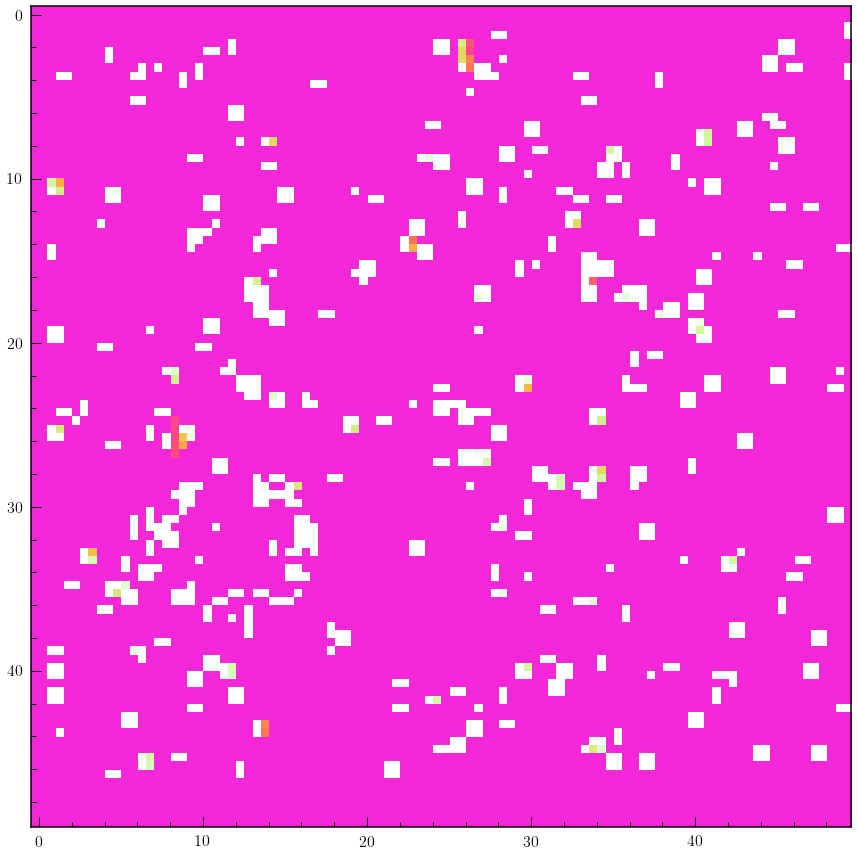

In [171]:
fig, ax = subplots(1,1, figsize=(12,12))
Blues = copy(cm.pink)
Blues.set_bad(color='black',alpha=1.0)
cmap = palettable.colorbrewer.diverging.Spectral_11.mpl_colormap
cmap = palettable.cubehelix.cubehelix3_16.mpl_colormap
cmap.set_bad(color="#FFFFFF", alpha = 1.0)
# How should we go about scaling the pixel data?  This seems to work OK for now
#raw = gen[0]
#print "Base",cont[0].pixels[0]
#raw = gen.get_zscore(0)
#print "Raw",raw
#img = raw
#img=bin_pixel_buffer(raw, (20,20))
#print "img",img
#img[img<0] = np.nan
#img = np.log10(np.abs(raw*1.0))*np.sign(raw*1.0)


# The initial Draw
im = ax.imshow(np.zeros((100,100)), interpolation="None", cmap=cmap, vmin = -1, vmax = 1, animated=True)
fig.tight_layout()

def init():
    return update(0)

def update(i):

    loader.update_bar(1.0*i/N)
    i = i
    if i >= 3853:
        return im,
    #raw = gen[i]
    raw = gen.get_zscore(i)
    #raw = np.nanmean([gen.get_zscore(j) for j in xrange(i,i+5)], axis=0) #This is a smoothing
    img = bin_pixel_buffer(raw, (100,100))
    if not np.isnan(img).all():
        img[np.isnan(img)] = 0.0
        im.set_array(img)
    #print 1.0*i/N
    return im,
    
anim = animation.FuncAnimation(fig, update, init_func=init, frames=N, interval=50, blit=True)

with loader:
    HTML(anim.to_html5_video())

In [174]:
# Run this cell to display the animation
rc('animation', html='html5')
anim



In [173]:
# Or this one to save it
with loader:
    anim.save('RollingBandC%iChannel%i.mp4' % (campaign, channel))

[/-----------------------------------------------------------]  

/home/rodot/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in log10


[#######\----------------------------------------------------]  

/home/rodot/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log10
